In [1]:
#Load up all the common functions. Required to execute other experiments
#Please reload if changes are made to the functions
%run Common_Experiment_Functions.ipynb

2022-02-23 01:42:20.766235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 01:42:20.766265: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 5.2 Acquire and Process Data

In [2]:
import pandas as pd
import os
import tensorflow as tf

def get_rca_data():
    #Load the data file into a Pandas Dataframe
    symptom_data = pd.read_csv("root_cause_analysis.csv")

    #Explore the data loaded
    #print(symptom_data.dtypes)
    #symptom_data.head()

    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split

    label_encoder = preprocessing.LabelEncoder()
    symptom_data['ROOT_CAUSE'] = label_encoder.fit_transform(
                                    symptom_data['ROOT_CAUSE'])

    #Convert Pandas DataFrame to a numpy vector
    np_symptom = symptom_data.to_numpy().astype(float)

    #Extract the feature variables (X)
    X_data = np_symptom[:,1:8]

    #Extract the target variable (Y), conver to one-hot-encoding
    Y_data=np_symptom[:,8]
    Y_data = tf.keras.utils.to_categorical(Y_data,3)

    return X_data,Y_data

## 5.3. Tuning the network

### 5.3.1. Layers in the network

In [3]:
accuracy_measures = {}
layer_list =[]
for layer_count in range(1,6):
    
    #32 nodes in each layer
    layer_list.append(32)
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Layers-" + str(layer_count)
    history=create_and_run_model(model_config,X,Y,model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]

2022-02-23 01:46:16.512874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 01:46:16.512910: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 01:46:16.512943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AD): /proc/driver/nvidia/version does not exist
2022-02-23 01:46:16.539726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



******************************************************
Model: "Layers-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Output-Layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 355
Trainable params: 355
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Layers-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 32)                1056   

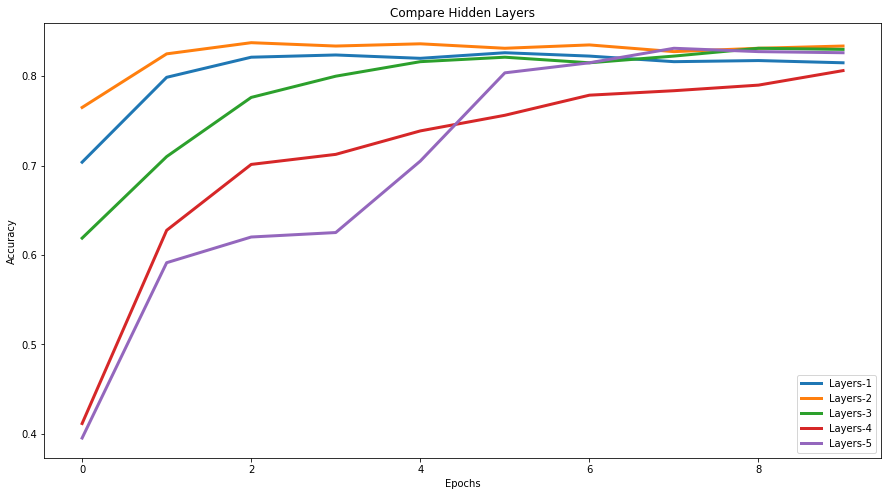

In [4]:
plot_graph(accuracy_measures, "Compare Hidden Layers")

### 5.3.2 Nodes in a Layer

In [5]:
accuracy_measures = {}

node_increment=8

for node_count in range(1,5):
    
    #have 2 hidden layers in the networks as selected above
    layer_list =[]
    for layer_count in range(2):
        layer_list.append(node_count * node_increment)
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["HIDDEN_NODES"] = layer_list
    model_name = "Nodes-" + str(node_count * node_increment)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Nodes-8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 8)                 64        
                                                                 
 Dense-Layer-1 (Dense)       (None, 8)                 72        
                                                                 
 Output-Layer (Dense)        (None, 3)                 27        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Nodes-16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                128     

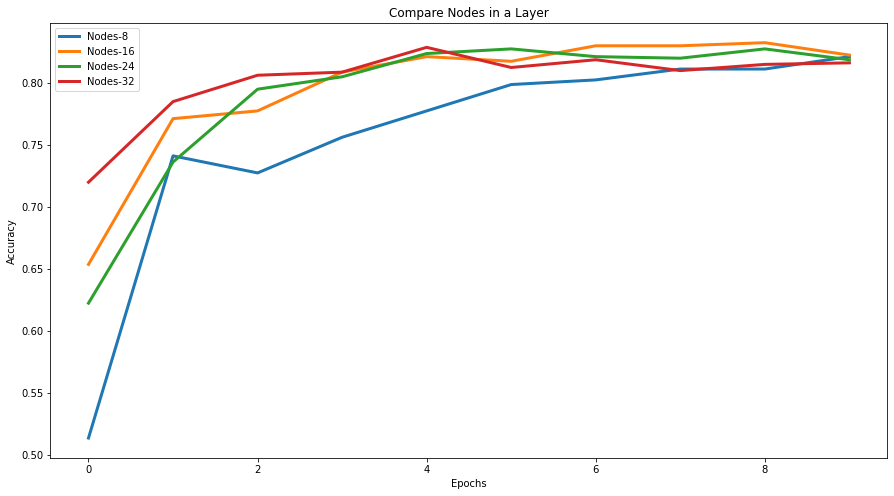

In [6]:
plot_graph(accuracy_measures, "Compare Nodes in a Layer")

## 5.4. Tuning Back Propagation

## 5.4.1. Optimizers

In [7]:
accuracy_measures = {}

optimizer_list = ['sgd','rmsprop','adam','adagrad']
for optimizer in optimizer_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["OPTIMIZER"] = optimizer
    model_name = "Optimizer-" + optimizer
    history=create_and_run_model(model_config,X,Y, model_name)
    
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Optimizer-sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Optimizer-rmsprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)     

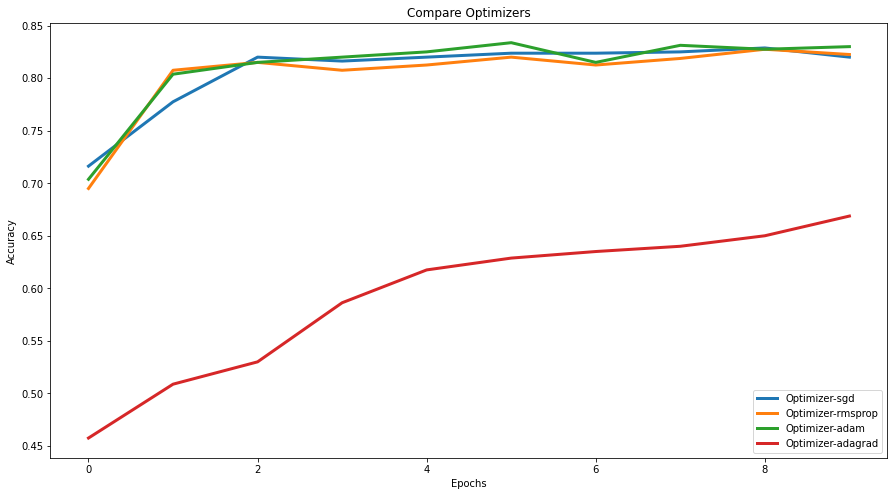

In [8]:
plot_graph(accuracy_measures, "Compare Optimizers")

### 5.4.2. Learning Rates

In [9]:

accuracy_measures = {}

learning_rate_list = [0.001, 0.005,0.01,0.1,0.5]
for learning_rate in learning_rate_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    #Fix Optimizer to the one chosen above
    model_config["OPTIMIZER"]="rmsprop"
    model_config["LEARNING_RATE"] = learning_rate
    model_name="Learning-Rate-" + str(learning_rate)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Using validation accuracy
    accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Learning-Rate-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Learning-Rate-0.005"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 

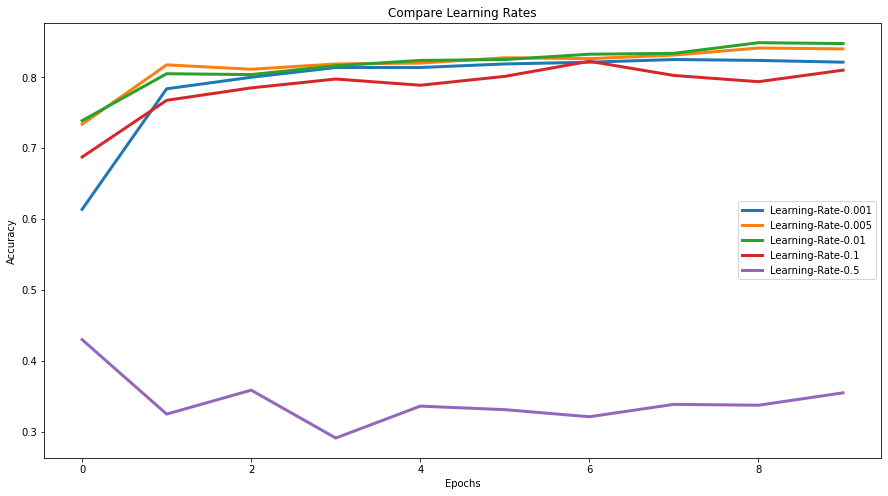

In [10]:
plot_graph(accuracy_measures, "Compare Learning Rates")

## 5.5. Avoiding Overfitting

### 5.5.1. Regularizer

In [11]:
accuracy_measures = {}

regularizer_list = [None,'l1','l2','l1_l2']
for regularizer in regularizer_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    model_config["REGULARIZER"] = regularizer
    model_name = "Regularizer-" + str(regularizer)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Switch to validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Regularizer-None"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Regularizer-l1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)     

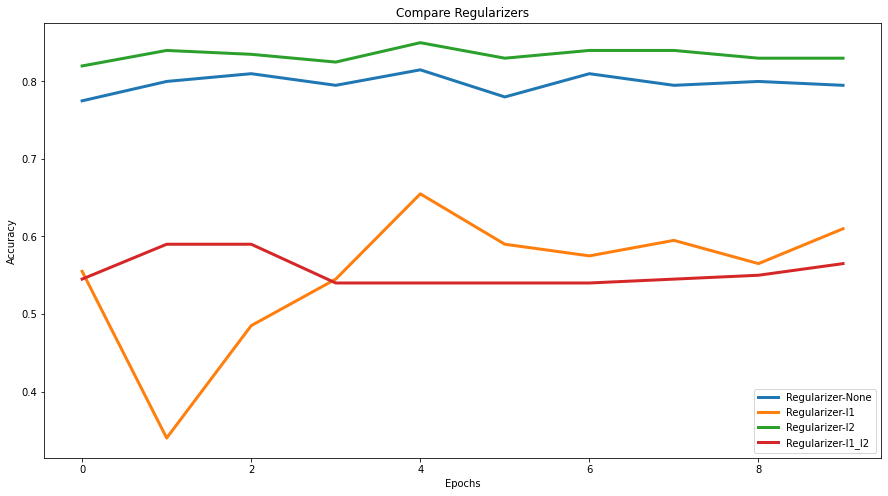

In [12]:
plot_graph(accuracy_measures, "Compare Regularizers")

### 5.5.2. Dropout

In [13]:
accuracy_measures = {}

dropout_list = [0.0, 0.1, 0.2, 0.5]
for dropout in dropout_list:
    
    model_config = base_model_config()
    X,Y = get_rca_data()
    
    #Use the regularizer chosen above
    model_config["REGULARIZER"] = "l2"
    model_config["DROPOUT_RATE"] = dropout
    model_name="Dropout-" + str(dropout)
    history=create_and_run_model(model_config,X,Y, model_name)
    
    #Using validation accuracy
    accuracy_measures[model_name] = history.history["val_accuracy"]


******************************************************
Model: "Dropout-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Dropout-0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)             

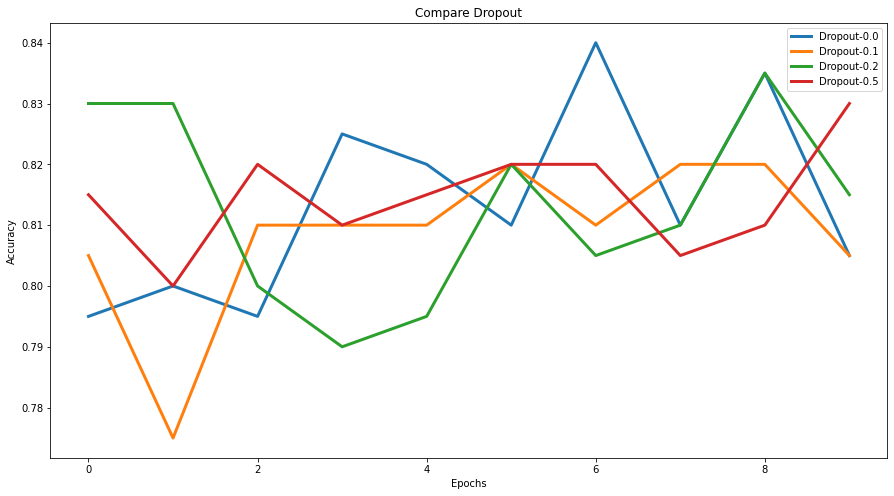

In [15]:
plot_graph(accuracy_measures, "Compare Dropout")

## 5.6. Building the final model

In [16]:
accuracy_measures = {}

#Base Minimal Model
model_config = base_model_config()
model_config["HIDDEN_NODES"] = [16]
model_config["NORMALIZATION"] = None
model_config["OPTIMIZER"] = "rmsprop"
model_config["LEARNING_RATE"] = 0.001
model_config["REGULARIZER"]=None
model_config["DROPOUT_RATE"] = 0.0

X,Y = get_rca_data()

model_name = "Base-Model-" + str(layer_count)

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]

#Adding all optimizations
model_config = base_model_config()
model_config["HIDDEN_NODES"] = [32,32]
model_config["NORMALIZATION"] = "batch"
model_config["OPTIMIZER"] = "rmsprop"
model_config["LEARNING_RATE"] = 0.001
model_config["REGULARIZER"]="l2"
model_config["DROPOUT_RATE"] = 0.2

X,Y = get_rca_data()

model_name = "Optimized-Model-" + str(layer_count)

history=create_and_run_model(model_config,X,Y,model_name)
    
accuracy_measures[model_name] = history.history["accuracy"]


******************************************************
Model: "Base-Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 16)                128       
                                                                 
 Output-Layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 179
Trainable params: 179
Non-trainable params: 0
_________________________________________________________________

******************************************************
Model: "Optimized-Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                256       
                                                                 
 batch_normalization (BatchN  (None, 32)         

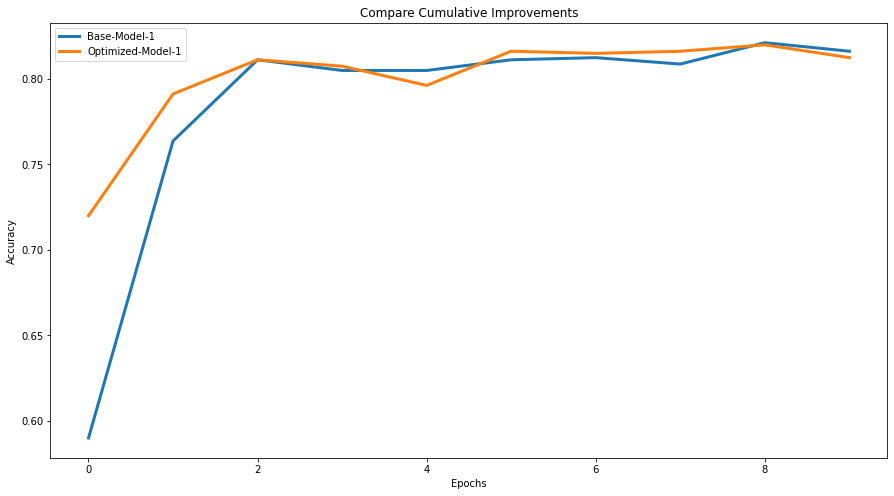

In [17]:
plot_graph(accuracy_measures, "Compare Cumulative Improvements")